## Importing the Necessary Libraries
#### Python libraries for data analysis, visualization, and machine learning are imported below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
import re
import ast

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Checking the DataFrames
#### and Data Inspection

In [6]:
df = pd.read_csv('Audible_Catlog_Advanced_Features.csv')
df2 = pd.read_csv('Audible_Catlog.csv')

In [7]:
df.head(2)

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."


In [8]:
df.isnull().sum()

Book Name              0
Author                 0
Rating                 0
Number of Reviews    421
Price                  0
Description            6
Listening Time         0
Ranks and Genre        0
dtype: int64

In [9]:
df.loc[616,'Description']='A high-energy guide that teaches how selling is essential in all aspects of life. Cardone shares powerful strategies to master persuasion, overcome rejection, and close any deal.'
df.loc[1715,'Description'] = 'Neuroscientist Daniel Levitin explores how to manage the overwhelming flood of information in modern life, offering practical systems to improve focus, decision-making, and productivity.'
df.loc[1920,'Description'] = 'A compilation of Tolle’s most profound teachings on mindfulness, presence, and spiritual awakening, helping listeners connect with the power of now and inner peace.'
df.loc[2870,'Description'] = 'A fast-paced thriller filled with espionage, danger, and mystery, this novel follows the intelligent and fearless Tracy Whitney as she unravels a deadly conspiracy.'
df.loc[3266,'Description'] = 'An engaging book that uses science to explain natural phenomena, debunk myths, and inspire wonder about the universe, aimed at readers young and old alike.'
df.loc[4261,'Description'] = 'A deep philosophical exploration of thought, awareness, and self-understanding, based on Krishnamurti’s dialogues that challenge conventional patterns of thinking.'

In [10]:
df2.head(2)

,Book Name,Author,Rating,Number of Reviews,Price
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0


In [11]:
df2.isnull().sum()

Book Name              0
Author                 0
Rating                 0
Number of Reviews    631
Price                  3
dtype: int64

In [12]:
df2.loc[6367,['Book Name','Author']] = ['Wire - Ek Kamuk Laghuta','Cecily Rosdale']
df2.loc[3192,['Book Name','Author']] = ["Tinder Taxi - Ek Kamuk Laghukatha", 'Lee Lind']

## Data Cleaning

In [13]:
df2['Price']=df2['Price'].fillna(method ='bfill')

In [14]:
df2.drop_duplicates(inplace=True)

In [15]:
df2['Rating'] = df2['Rating'].apply(lambda x:0 if x<0 else x) # replaces negative values with zero

#### Merging the both dataframe into one named as datas

In [16]:
datas = df.merge(df2,on=['Book Name','Author','Rating','Price','Number of Reviews'],how='left')
datas.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."


In [17]:
datas.shape

(4464, 8)

In [18]:
# Convert 'Listening Time' from string to total minutes
def convert_to_minutes(time_str):
    parts = time_str.split(" ")
    hours = 0
    minutes = 0
    if "hour" in parts:
        hours = int(parts[parts.index("hour") - 1])
    elif "hours" in parts:
        hours = int(parts[parts.index("hours") - 1])
    if "minute" in parts:
        minutes = int(parts[parts.index("minute") - 1])
    elif "minutes" in parts:
        minutes = int(parts[parts.index("minutes") - 1])
    return hours * 60 + minutes

datas['Listening Time (min)'] = datas['Listening Time'].apply(convert_to_minutes)


In [19]:
def extract_ranked_genres(text):
    ranked_genres = []
    if isinstance(text, str):
        matches = re.findall(r'#(\d+) in ([^,(]+)', text)
        ranked_genres = [{"rank": int(rank), "genre": genre.strip()} for rank, genre in matches]
    return ranked_genres

# Assuming your DataFrame is named 'df' and the relevant column is 'Ranks and Genre'
datas['Ranked_Genres'] = datas['Ranks and Genre'].apply(extract_ranked_genres)

In [20]:
datas.iloc[0].Ranked_Genres

[{'rank': 1, 'genre': 'Audible Audiobooks & Originals'},
 {'rank': 1, 'genre': 'Personal Success'},
 {'rank': 1, 'genre': 'Stress Management'},
 {'rank': 2, 'genre': 'Society & Culture'}]

In [21]:
def convert(val):
    L=[]
    for i in (val):
        L.append(i['genre'])
    return L

In [22]:
datas['Genres']=datas['Ranked_Genres'].apply(convert)

In [23]:
datas.iloc[0].Genres

['Audible Audiobooks & Originals',
 'Personal Success',
 'Stress Management',
 'Society & Culture']

In [24]:
datas = datas.drop(columns=['Ranked_Genres','Ranks and Genre','Listening Time'],axis=1)
datas.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (min),Genres
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",654,"[Audible Audiobooks & Originals, Personal Succ..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,203,"[Audible Audiobooks & Originals, Meditation, S..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",317,"[Audible Audiobooks & Originals, Personal Succ..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,335,"[Audible Audiobooks & Originals, Psychology, S..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",385,"[Audible Audiobooks & Originals, Literary Essa..."


In [25]:
df = datas

df['Genres'] = df['Genres'].fillna("[]").astype(str) # fill empty value of genre with [] 
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x) if x.strip() != "" else []) #convert the strings into actual Python lists
df['Description'] = df['Description'].fillna("").astype(str) # fill empty description with ""

In [26]:
# Identify missing genres
missing_gen = df['Genres'].apply(lambda x: not x)
missing_gen.sum()

2363

In [27]:
known_df = df[~missing_gen].copy()
missing_df = df[missing_gen].copy()

# Remove empty descriptions
known_df = known_df[known_df['Description'].str.strip() != ""]
missing_df = missing_df[missing_df['Description'].str.strip() != ""]

## Feature encoding and Vectorization

In [28]:
#  transforming raw text into a sparse matrix of features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
combined_descriptions = pd.concat([known_df['Description'], missing_df['Description']])
tfidf = vectorizer.fit_transform(combined_descriptions)

In [29]:
# Separate vectors
known_tfidf = tfidf[:len(known_df)]
missing_tfidf = tfidf[len(known_df):]

# Similarity
sim = cosine_similarity(missing_tfidf, known_tfidf)
most_similar = sim.argmax(axis=1)

# Assign genres from most similar known description
missing_df['Genres'] = known_df.iloc[most_similar]['Genres'].values

### Here , we have applied cosine similarity to get the similar values based in descriptions

In [30]:
# Merge
datas = pd.concat([known_df, missing_df]).sort_index()

In [31]:
datas['Genres'].value_counts()

Genres
[Personal Success]                                                                       1171
[Science Fiction Anthologies & Short Stories, Fiction Short Stories]                      629
[Classic Literature]                                                                       30
[Leadership, Business Careers]                                                             25
[Contemporary Romance]                                                                     21
                                                                                         ... 
[Religion & Spirituality, Personal Success, Christianity]                                   1
[Audible Audiobooks & Originals, Other Religions, Personal Success, Mind]                   1
[Dogs Fiction for Children, Pets Fiction for Children, Fiction Classics for Children]       1
[Business Ethics, Israel & Palestine History, Economic Conditions]                          1
[Words, Business Communication, Communication & Socia

In [32]:
datas.rename(columns={'Book Name':'Book_Name'},inplace=True)

In [33]:
datas['Rating'].value_counts()

Rating
 4.6    760
 4.5    665
 4.7    625
 4.4    506
-1.0    421
 4.3    357
 4.8    269
 4.2    232
 4.1    143
 4.0    108
 5.0     99
 3.9     56
 4.9     49
 3.8     35
 3.7     35
 3.4     15
 3.6     15
 3.5     14
 3.0     12
 3.1      7
 1.0      7
 3.2      6
 3.3      6
 2.5      4
 2.6      4
 2.0      3
 2.9      3
 2.7      3
 2.4      2
 1.9      1
Name: count, dtype: int64

In [34]:
valid_rate = round(datas[datas['Rating']!=-1]['Rating'].mean(),1) # calculating  the average valid rating

In [35]:
datas['Rating'] = datas['Rating'].replace(-1,valid_rate) #replacing with valid rate (mean)

In [36]:
datas['Rating'].value_counts()

Rating
4.5    1086
4.6     760
4.7     625
4.4     506
4.3     357
4.8     269
4.2     232
4.1     143
4.0     108
5.0      99
3.9      56
4.9      49
3.8      35
3.7      35
3.4      15
3.6      15
3.5      14
3.0      12
3.1       7
1.0       7
3.2       6
3.3       6
2.5       4
2.6       4
2.0       3
2.9       3
2.7       3
2.4       2
1.9       1
Name: count, dtype: int64

In [37]:
datas['Number of Reviews'] = datas['Number of Reviews'].fillna(method='bfill')

In [38]:
datas.describe()

,Rating,Number of Reviews,Price,Listening Time (min)
count,4462.000000,4462.000000,4462.000000,4462.000000
mean,4.457530,1044.414164,942.236889,299.944420
std,0.335751,2837.542393,1622.389607,505.958298
min,1.000000,1.000000,0.000000,0.000000
25%,4.400000,70.000000,501.000000,0.000000
50%,4.500000,259.000000,683.000000,0.000000
75%,4.600000,884.000000,888.000000,480.750000
max,5.000000,70122.000000,18290.000000,7591.000000


#### Finding the top 10 distribution of the Genres

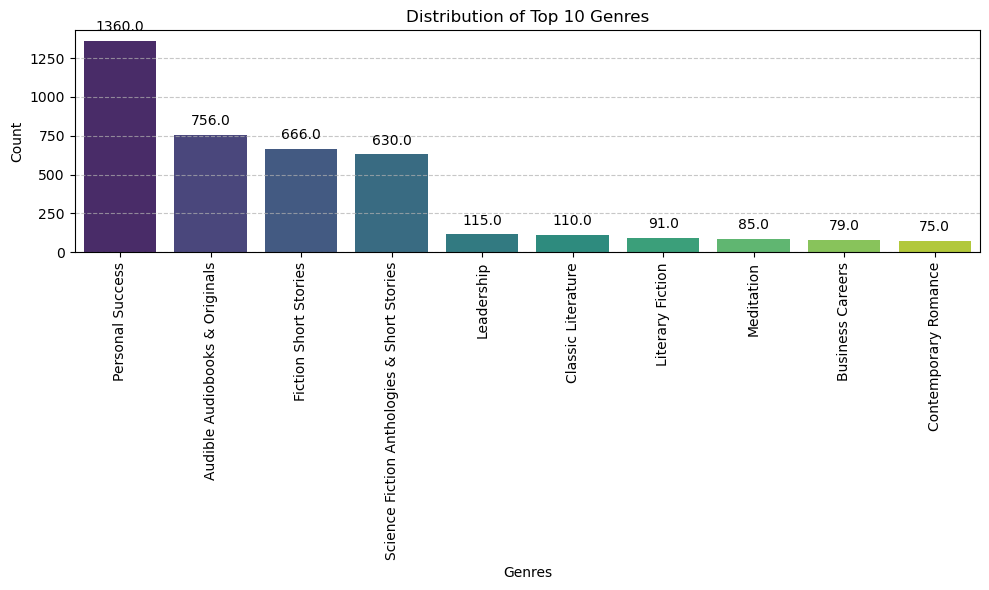

In [39]:
# Flatten
all_genres = [genre for sublist in datas['Genres'] for genre in sublist]
genre_counts = Counter(all_genres)
top_10_genres = genre_counts.most_common(10)
top_10_genres_df = pd.DataFrame(top_10_genres, columns=['Genre', 'Count'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Genre', y='Count', data=top_10_genres_df, palette='viridis')
plt.xticks(rotation=90)
plt.title("Distribution of Top 10 Genres")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.tight_layout()
plt.grid(True,axis='y',linestyle='--',alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',(p.get_x()+p.get_width()/2.,p.get_height()),
                ha='center',va='center',xytext=(0,10),textcoords='offset points')
plt.show()

#### Highest Rating with the Author Name

In [40]:
# Group by 'Author' and get the maximum rating for each author
author_max_ratings = datas.groupby('Author')['Rating'].max().sort_values(ascending=False)

# Get the authors with the highest maximum ratings
top_authors = author_max_ratings.head(10)
top_100_authors = author_max_ratings.head(100)

# Display the authors and their highest ratings
print("Authors with the highest-rated books:")
print(top_authors)

Authors with the highest-rated books:
Author
Vella Day                  5.0
Werner Heidemann           5.0
DK                         5.0
Roberta H. Anding          5.0
Cyndi Dale                 5.0
Harvard Business Review    5.0
Shobha Viswanath           5.0
J. Krishnamurti            5.0
Simone Ahuja               5.0
Timothy Zahn               5.0
Name: Rating, dtype: float64


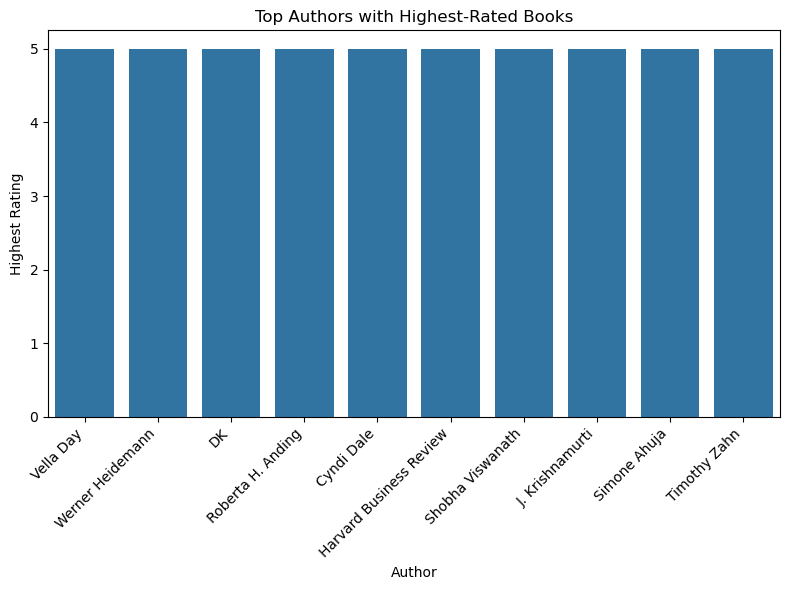

In [41]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_authors.index, y=top_authors.values)
plt.title("Top Authors with Highest-Rated Books")
plt.xlabel("Author")
plt.ylabel("Highest Rating")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Booking With Highest Rating

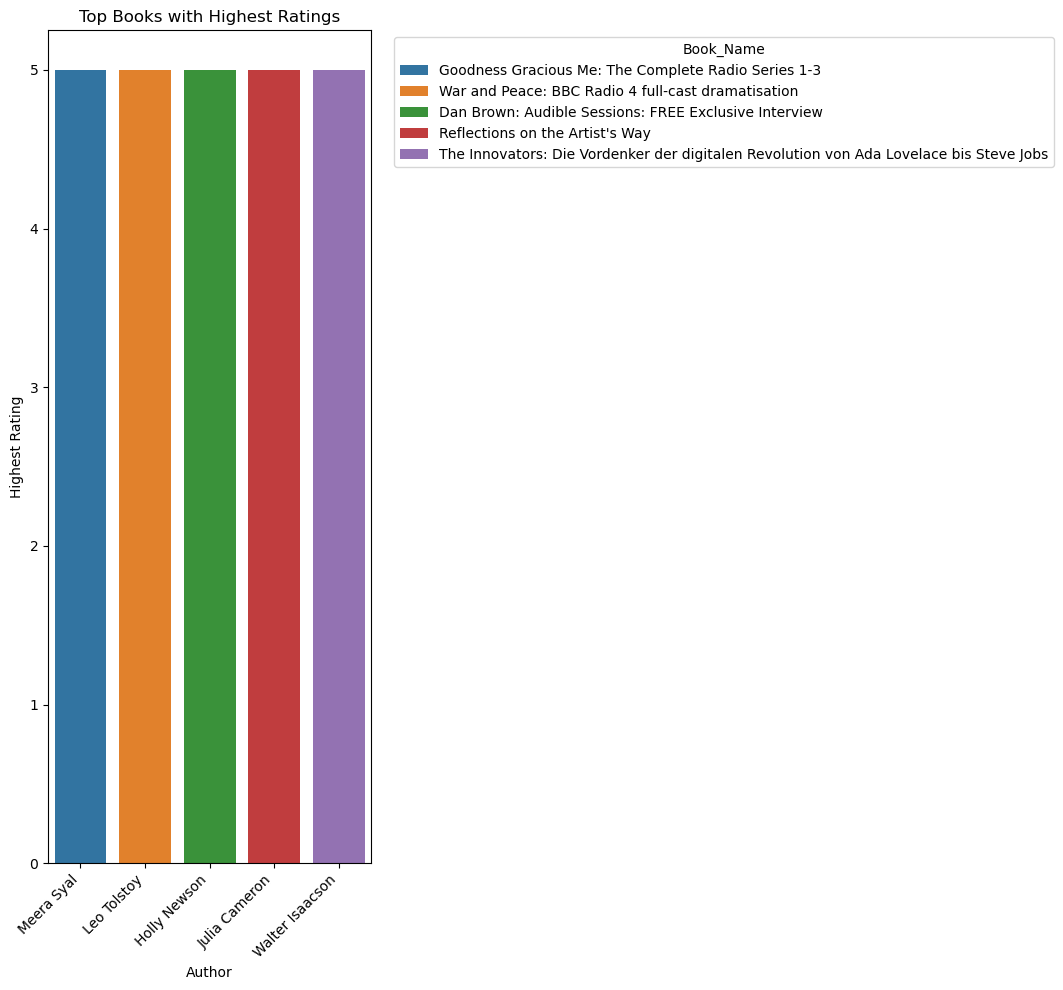

In [42]:
author_book_max_ratings = datas.groupby(['Author', 'Book_Name'])['Rating'].max().reset_index()

# Sort by rating in descending order and get the top 5
top_books = author_book_max_ratings.sort_values(by=['Rating'], ascending=False).head(5)

# Create a bar plot
plt.figure(figsize=(11, 10))  # Adjust figure size if needed
sns.barplot(x='Author', y='Rating', hue='Book_Name', data=top_books, dodge=False)
plt.title("Top Books with Highest Ratings")
plt.xlabel("Author")
plt.ylabel("Highest Rating")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Book_Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Average Rating Given to the Book

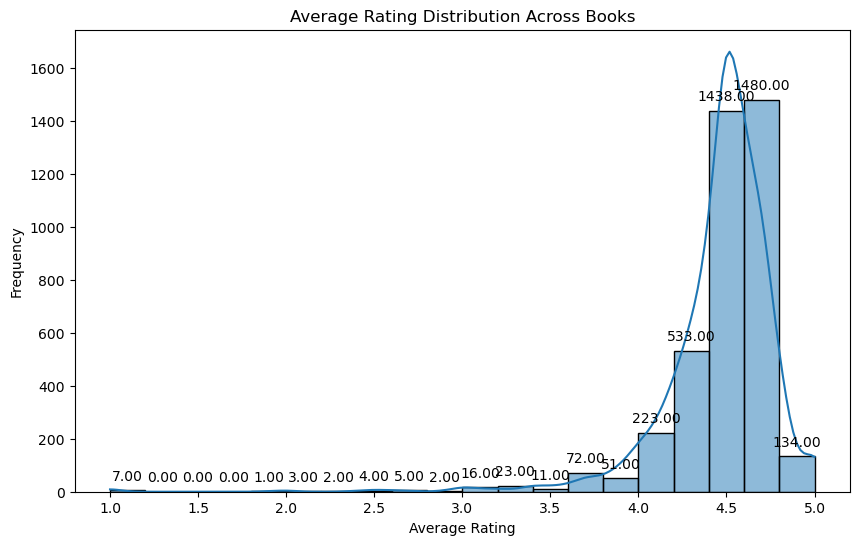

In [43]:
average_rating_per_book = datas.groupby('Book_Name')['Rating'].mean()

plt.figure(figsize=(10, 6))
ax=sns.histplot(average_rating_per_book,bins=20,kde=True)
plt.title("Average Rating Distribution Across Books")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/2.,p.get_height()),
                ha='center',va='center',xytext=(0,10),textcoords='offset points')
plt.show()

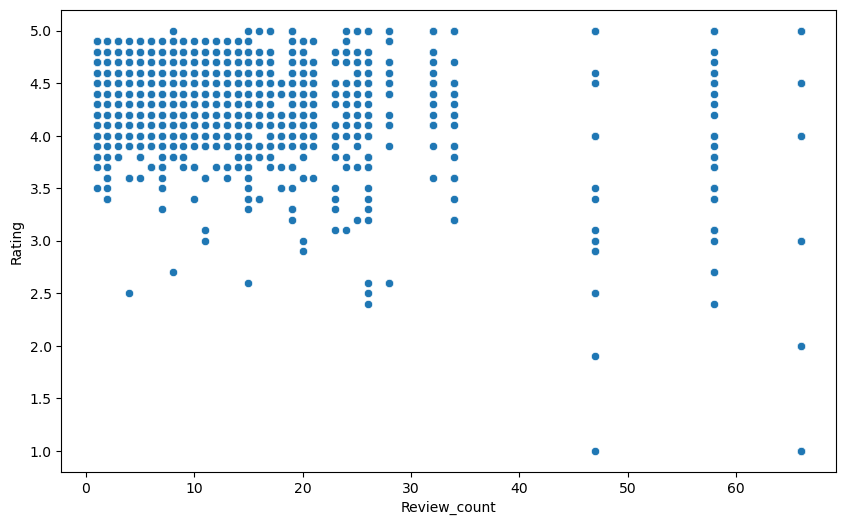

In [44]:
Review_count = datas['Number of Reviews'].value_counts().reset_index()
Review_count.columns = ['Number of Reviews', 'Review_count']  # Rename columns for clarity
datas = datas.merge(Review_count, on='Number of Reviews', how='left')  # Merge based on 'Number of Reviews'

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Review_count', y='Rating', data=datas)
plt.show()

## Detecting the Different Languages and Converting it to the English One

In [45]:
!pip install langdetect

In [46]:
from langdetect import detect, DetectorFactory

# Ensures consistent results
DetectorFactory.seed = 0

# Sample: Detect language in 'Book_Name' column
def detect_language(text):
    try:
        return detect(str(text))
    except:
        return "unknown"

datas['lang'] = datas['Book_Name'].apply(detect_language)


In [47]:
datas['lang'].value_counts()

lang
en         3948
de          106
id           67
tl           42
nl           34
it           30
so           24
no           21
fr           19
af           16
et           16
da           13
ro           13
ca           12
cy           12
sv           12
sw           11
hi            9
tr            8
fi            8
pt            7
es            7
sl            6
hr            5
lt            5
sq            4
unknown       3
lv            2
vi            1
pl            1
Name: count, dtype: int64

In [48]:
hindi_books = datas[datas['lang'] == 'hi']
hindi_books

,Book_Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (min),Genres,Review_count,lang
990,द निम्फ़ एंड द फ़ॉन्स - एक कामुक लघुकथा,ओलरिक,4.5,285.0,32,"""पांच मर्द फ़र वाले पैजामे में उछल रहे थे और उन...",37,[Erotic Fiction],6,hi
991,द निम्फ़ एंड द फ़ॉन्स - एक कामुक लघुकथा,ओलरिक,4.5,285.0,32,"""पांच मर्द फ़र वाले पैजामे में उछल रहे थे और उन...",37,[Erotic Fiction],6,hi
3189,टिंडर टैक्सी - एक कामुक लघुकथा,ली लिंड,4.5,4104.0,65,"Sorry, we just need to make sure you're not a ...",0,[Personal Success],4,hi
3203,टिंडर टैक्सी - एक कामुक लघुकथा,ली लिंड,4.5,4104.0,65,"""हम काली स्याह रात में गाड़ी चलाते रहे। मैं अपन...",0,"[Audible Audiobooks & Originals, Personal Succ...",4,hi
3349,कार सेक्स - एक कामुक लघुकथा,साराह स्‍कोव,4.5,233.0,65,\n\nOops!\nIt's rush hour and traffic is pilin...,0,"[Science Fiction Anthologies & Short Stories, ...",8,hi
4420,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,4.5,85.0,65,"Sorry, we just need to make sure you're not a ...",0,[Personal Success],16,hi
4421,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,4.5,85.0,32,"Sorry, we just need to make sure you're not a ...",0,[Personal Success],16,hi
4438,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,4.5,85.0,65,"""इस होटल में कुछ खास बात है, जो कि जहाँ तक मैं...",0,"[Audible Audiobooks & Originals, Literary Fict...",16,hi
4439,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,4.5,85.0,32,"Sorry, we just need to make sure you're not a ...",0,[Personal Success],16,hi


In [49]:
!pip install deep-translator

In [50]:
from deep_translator import GoogleTranslator

In [51]:
def hindi_to_hinglish(text):
    translated = GoogleTranslator(source='hi',target='en').translate(text)
    return translated

In [52]:
def translate_col(df,columns):
    for column in columns:
     df[column] = datas.apply(
    lambda row :hindi_to_hinglish(row[column]) if row['lang'] == 'hi' else row[column],axis=1)
    return df

In [53]:
columns_to_translate = ['Book_Name','Author','Description']
datas = translate_col(datas,columns_to_translate)

In [54]:
datas['Book_Name'] = datas.apply(
    lambda row: hindi_to_hinglish(row['Book_Name']) if row['lang'] == 'hi' else row['Book_Name'], axis=1
)

In [55]:
datas['Book_Name']

0       Think Like a Monk: The Secret of How to Harnes...
1       Ikigai: The Japanese Secret to a Long and Happ...
2       The Subtle Art of Not Giving a F*ck: A Counter...
3       Atomic Habits: An Easy and Proven Way to Build...
4       Life's Amazing Secrets: How to Find Balance an...
                              ...                        
4457    Factfulness: Wie wir lernen, die Welt so zu se...
4458         Late-Talking Children: A Symptom or a Stage?
4459    The Marketing of Evil: How Radicals, Elitists ...
4460        Things I Wish I'd Known Before We Got Married
4461    The Disease Delusion: Conquering the Causes of...
Name: Book_Name, Length: 4462, dtype: object

In [56]:
datas = datas.drop(columns='lang')

In [57]:
datas.sample()

,Book_Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (min),Genres,Review_count
1840,"The Protectors Series 13, Viktor",Teresa Gabelman,4.9,229.0,586,\n\nOops!\nIt's rush hour and traffic is pilin...,0,"[Science Fiction Anthologies & Short Stories, ...",9


In [58]:
# datas.to_csv("ready_book.csv")

In [59]:
datas['Genres']

0       [Audible Audiobooks & Originals, Personal Succ...
1       [Audible Audiobooks & Originals, Meditation, S...
2       [Audible Audiobooks & Originals, Personal Succ...
3       [Audible Audiobooks & Originals, Psychology, S...
4       [Audible Audiobooks & Originals, Literary Essa...
                              ...                        
4457                                   [Personal Success]
4458                                   [Personal Success]
4459    [Audible Audiobooks & Originals, Meditation, M...
4460    [Science Fiction Anthologies & Short Stories, ...
4461    [Audible Audiobooks & Originals, Contemporary ...
Name: Genres, Length: 4462, dtype: object

In [60]:
# datas['Genres'] = datas['Genres'].apply(lambda x:x if isinstance(x,list) else [])
# datas['Genres_text'] = datas['Genres'].apply(lambda x: ' '.join(x))
# genrs_tfidf = vectorizer.fit_transform(datas['Genres_text'])

### Applying Scaling and MultiLabelBinarizer 

In [61]:
datas['Genres'] = datas['Genres'].apply(lambda x:x if isinstance(x,list) else [])

mlb = MultiLabelBinarizer()
Genres_encoded = mlb.fit_transform(datas['Genres'])
Genres_df = pd.DataFrame(Genres_encoded, columns=mlb.classes_)

numerical = ['Rating','Price','Number of Reviews','Listening Time (min)']
scaler = StandardScaler()
scaled = scaler.fit_transform(datas[numerical])
scaled_df = pd.DataFrame(scaled, columns=numerical)

In [62]:
features_for_clustering = pd.concat([scaled_df,Genres_df],axis=1)

## Clustering and Dimensionality Reduction¶
Apply unsupervised learning techniques like KMeans and reduce dimensions with PCA for better visualization or modeling.

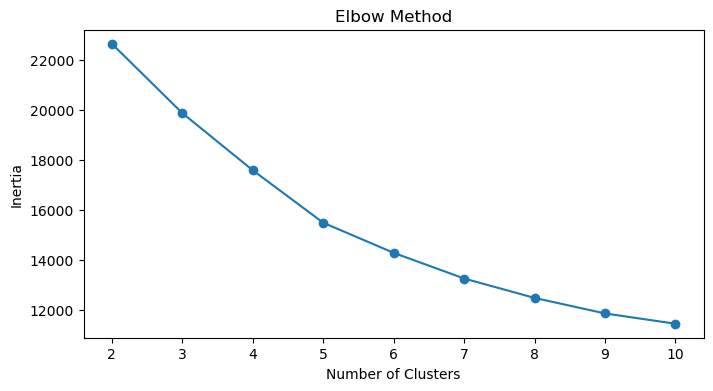

In [63]:
inertia = []
for n_clusters in range(2,11):
  kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=10)
  kmeans.fit(features_for_clustering)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2,11),inertia,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

### Elbow Method to find the Optimal Value for the number Cluster for Better Spread of the Cluster

In [64]:
optimal_cluster = 5
kmeans = KMeans(n_clusters=optimal_cluster,random_state=42,n_init=10)
datas['cluster'] = kmeans.fit_predict(features_for_clustering)

In [65]:
print("\nBooks in Cluster 0 (based on descriptions):")
print(datas[datas['Description'] == 0]['Book_Name'].head(10))



Books in Cluster 0 (based on descriptions):
Series([], Name: Book_Name, dtype: object)


#### Average Rating per Cluster

In [66]:
print("\nAverage Rating per Cluster:")
print(datas.groupby('cluster')['Rating'].mean())


Average Rating per Cluster:
cluster
0    4.496512
1    3.885308
2    4.566772
3    4.503846
4    4.510577
Name: Rating, dtype: float64


In [67]:
print("\nCluster centroids on scaled features space")
print(pd.DataFrame(kmeans.cluster_centers_,columns=features_for_clustering.columns))


Cluster centroids on scaled features space
     Rating     Price  Number of Reviews  Listening Time (min)  \
0  0.116115  6.601788           0.210697              0.179642   
1 -1.704498 -0.181732          -0.270069             -0.313359   
2  0.325401 -0.163866          -0.107170             -0.367754   
3  0.137963  0.270983           7.067528              0.538562   
4  0.158012  0.002023           0.110243              1.449892   

   20th Century Historical Romance  Absurdist Fiction  Abusive Relationships  \
0                     0.000000e+00       2.710505e-20           2.710505e-20   
1                     5.421011e-19      -3.523657e-19          -3.523657e-19   
2                     3.497726e-04       3.252607e-19           3.497726e-04   
3                    -1.084202e-19       0.000000e+00           0.000000e+00   
4                     2.403846e-03       1.201923e-03          -1.761829e-18   

   Acting & Auditioning  Action & Adventure Anthologies & Short Stories  \
0  

## PCA (Dimensionality Reduction)

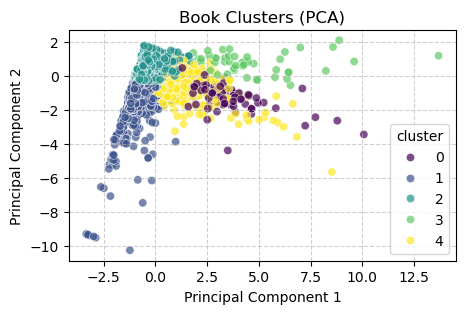

In [68]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_for_clustering)

# Create a DataFrame for plotting the PCA results
pca_df = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])

# Add the cluster labels to the PCA DataFrame
pca_df['cluster'] = datas['cluster']

# Create the scatter plot
plt.figure(figsize=(5, 3))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster',  # Color points by cluster
    data=pca_df,
    palette='viridis', # Use a colormap
    legend='full',     # Show the legend for clusters
    alpha=0.7          # Make points slightly transparent
)

plt.title('Book Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid
plt.show()

In [168]:
from sklearn.metrics import silhouette_score
print(f"Inertia: {kmeans.inertia_:.2f}")
# Calculating Silhouette Score
try:
    score = silhouette_score(features_for_clustering, kmeans.labels_)
    print(f"Silhouette Score: {score:.4f}")
except Exception as e:
    print(f"Could not calculate Silhouette Score: {e}")


Inertia: 15496.09
Silhouette Score: 0.2127


## Performing more Visualization for better Understanding
### Science Fiction Books

In [69]:
sci_book = datas[datas['Genres'].apply(lambda x: 'Science Fiction' in x)]
recom_sci_books = sci_book.sort_values(by=['Rating','Number of Reviews'],ascending=False)
recom = recom_sci_books.head(5)

print("Top 5 Recommended Science Fiction Books")
print(recom[['Book_Name','Author','Rating','Number of Reviews']])

Top 5 Recommended Science Fiction Books
                                              Book_Name            Author  \
3475                      The Last Hours: Chain of Gold   Cassandra Clare   
1965  Doctor Who: 10th Doctor Tales: 10th Doctor Aud...  Peter Anghelides   
1967  Doctor Who: 10th Doctor Tales: 10th Doctor Aud...  Peter Anghelides   
2404                                 Thrawn (Star Wars)      Timothy Zahn   
2304                   Percy Jackson and the Greek Gods      Rick Riordan   

      Rating  Number of Reviews  
3475     4.8             1915.0  
1965     4.8                9.0  
1967     4.8                9.0  
2404     4.7             2328.0  
2304     4.7             1668.0  


### Thriller books

In [70]:
thriller_book = datas[datas['Genres'].apply(lambda x: 'Thriller' in x)]
thriller_genre = thriller_book.sort_values(by=['Rating','Number of Reviews'],ascending=False)
recom = thriller_genre.head(5)

print("Top 5 Recommended Thriller Fiction Books")
print(recom[['Book_Name','Author','Rating','Number of Reviews']])

Top 5 Recommended Thriller Fiction Books
Empty DataFrame
Columns: [Book_Name, Author, Rating, Number of Reviews]
Index: []


## Hidden Books 

In [71]:
rating_threshold = datas['Rating'].quantile(0.8)
review_count_threshold = datas['Number of Reviews'].quantile(0.2)
highly_rated = datas[datas['Rating']>=rating_threshold]

hidden_gems = highly_rated[highly_rated['Number of Reviews']<=review_count_threshold]
hidden_gems_sorted = hidden_gems.sort_values(by=['Rating','Number of Reviews'],ascending=False)

top_hidden = hidden_gems_sorted.head(10)

print("Top 5 Hidden Gems")
print(top_hidden[['Book_Name','Author','Rating','Number of Reviews']])

Top 5 Hidden Gems
                                              Book_Name           Author  \
3112            Raven’s Hart: Haven Hart Series, Book 7    Davidson King   
2348  Energy Healing for Trauma, Stress & Chronic Il...       Cyndi Dale   
3786  Naked and Unafraid: 5 Keys to Abandon Smallnes...     Kevin Gerald   
2520  Coming Home to Yourself: A Meditator's Guide t...             Osho   
1725  Discover Your True North: Expanded and Updated...      Bill George   
1731  Discover Your True North: Expanded and Updated...      Bill George   
2510  Selling Technology the Sandler Way: Finding Te...   Rich Chiarello   
2366  Fighting for You: Bragan University Series, Bo...  Gianna Gabriela   
4425  Enterprise Agility: Being Agile in a Changing ...     Sunil Mundra   
4443  Enterprise Agility: Being Agile in a Changing ...     Sunil Mundra   

      Rating  Number of Reviews  
3112     5.0               37.0  
2348     5.0               17.0  
3786     5.0               17.0  
2520     

In [72]:
datas['Genres'].value_counts()

Genres
[Personal Success]                                                                       1171
[Science Fiction Anthologies & Short Stories, Fiction Short Stories]                      629
[Classic Literature]                                                                       30
[Leadership, Business Careers]                                                             25
[Contemporary Romance]                                                                     21
                                                                                         ... 
[Religion & Spirituality, Personal Success, Christianity]                                   1
[Audible Audiobooks & Originals, Other Religions, Personal Success, Mind]                   1
[Dogs Fiction for Children, Pets Fiction for Children, Fiction Classics for Children]       1
[Business Ethics, Israel & Palestine History, Economic Conditions]                          1
[Words, Business Communication, Communication & Socia

## Checking The Author Popularity Based on the Total Reviews he Got.

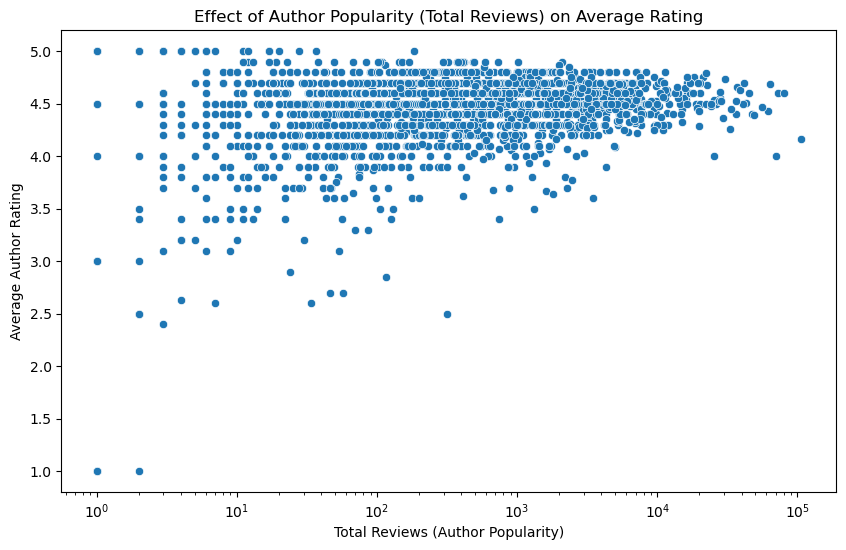


Correlation between Author Popularity and Average Rating: 0.05


In [73]:

author_popularity = datas.groupby('Author')['Number of Reviews'].sum().reset_index()
author_popularity.rename(columns={'Number of Reviews': 'Total_Reviews'}, inplace=True)

#  average rating per author
author_average_rating = datas.groupby('Author')['Rating'].mean().reset_index()

# Merge 
author_analysis = pd.merge(author_popularity, author_average_rating, on='Author')


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Reviews', y='Rating', data=author_analysis)
plt.title('Effect of Author Popularity (Total Reviews) on Average Rating')
plt.xlabel('Total Reviews (Author Popularity)')
plt.ylabel('Average Author Rating')
plt.xscale('log') # Use log scale for Total_Reviews if the range is large
plt.show()


correlation = author_analysis['Total_Reviews'].corr(author_analysis['Rating'])
print(f"\nCorrelation between Author Popularity and Average Rating: {correlation:.2f}")


## Checking the Books in the different Clusters(0,1,2,3,4) 
### Here Cluster 0 

In [74]:
tfidf_vectorizer_desc = TfidfVectorizer(stop_words='english', max_features=1000)
description_tfidf = tfidf_vectorizer_desc.fit_transform(datas['Description'])

optimal_n_clusters_desc = 5

kmeans_desc = KMeans(n_clusters=optimal_n_clusters_desc, random_state=42, n_init=10)
datas['cluster_description'] = kmeans_desc.fit_predict(description_tfidf)


print("\nBooks in Cluster 0 (based on descriptions):")
print(datas[datas['cluster_description'] == 0]['Book_Name'].head(10))


Books in Cluster 0 (based on descriptions):
48     The Hard Thing About Hard Things: Building a B...
51     Men Are from Mars, Women Are from Venus: The C...
57                                           Hit Refresh
58                           A Suitable Boy (Dramatised)
59     Take Control of Your Life: How to Silence Fear...
60     The 10X Rule: The Only Difference Between Succ...
61     A Game of Thrones: Book 1 of A Song of Ice and...
144                Breath: The New Science of a Lost Art
145                                               Origin
146                           Chinta Chhodo Sukh Se Jiyo
Name: Book_Name, dtype: object
